# Hyperparameter Tuning of Tennis Reinforcement Learning

This notebook determines the best set of hyperparameters to solve the Tennis enviornment as quickly as possible.

#### Import necessary modules

In [39]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import boto3
from IPython.display import Image
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.session import Session
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import shutil


#### Set local parameters

In [23]:
image_type = 'cpu'
instance_type = 'ml.m5.large'
n_epochs = 3000
n_instances = 1

#### Set the hyperparameters to optimize
The following hyperparameters are read from the command line in [train.py](container/src/train.py).

| Name        | Type  | Default | Description                        |
|-------------|-------|---------|------------------------------------|
| epochs      | int   |    2000 | number of total epochs to run      |
| max_t       | int   |    1000 | max number of time steps per epoch |
| fc1         | int   |     128 | size of 1st hidden layer           |
| fc2         | int   |      64 | size of 2bd hidden layer           |
| lr_actor    | float |   0.001 | initial learning rate for actor    |
| lr_critic   | float |   0.001 | initial learning rate for critic   |
| batch_size  | int   |     256 | mini batch size                    |
| buffer_size | int   |  100000 | replay buffer size                 |
| gamma       | float |     0.9 | discount factor                    |
| tau         | float |   0.001 | soft update of target parameters   |
| sigma       | float |    0.01 | OU Noise standard deviation        |

Any of these could be tuned but we will down select to limit the search.    

The hyperparameter tunner allow the hyperparameters to be defined as one of the following types. 
- `CategoricalParameter(list)` Categorical parameters need to take one value from a discrete set. 
- `ContinuousParameter(min, max)` Continuous parameters can take any real number value between the minimum and maximum value.
- `IntegerParameter(min, max)` Integer parameters can take any integer value between the minimum and maximum value.

_Note, if possible, it's almost always best to specify a value as the least restrictive type. For example, tuning learning rate as a continuous value between 0.01 and 0.2 is likely to yield a better result than tuning as a categorical parameter with values 0.01, 0.1, 0.15, or 0.2. Some parameters are categorical to maintain a power 2 structure and limit the search space._

In [24]:
hyperparameter_ranges = {
    'fc1': CategoricalParameter([64, 128]),
    'fc2': CategoricalParameter([32, 64]),
    'lr_actor': ContinuousParameter(0.0001, 0.01),
    'lr_critic': ContinuousParameter(0.0001, 0.01),
    'batch_size': CategoricalParameter([128,256]),
    'buffer_size': CategoricalParameter([10000,100000]),
    'gamma': ContinuousParameter(0.85, 0.95),
    'tau': ContinuousParameter(0.0001, 0.01),
    'sigma': ContinuousParameter(0.001, 0.1),
    }


#### Set the objective
Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. In this particular case, our script emits the total trainging episodes and we will use it as the objective metric, we also set the objective_type to be 'Minimize', so that hyperparameter tuning seeks to minize the objective metric when searching for the best hyperparameter setting. By default, objective_type is set to 'Maximize'.

In [25]:
objective_metric_name = 'time to solve'
objective_type = 'Minimize'
metric_definitions = [{'Name': objective_metric_name,
                       'Regex': '(\S+) training objective.'}]

#### Compile environment

In [26]:
role = get_execution_role()
account = boto3.client('sts').get_caller_identity()['Account']
region = boto3.Session().region_name
image_name = '{}.dkr.ecr.{}.amazonaws.com/sagemaker-tennis-{}:latest'.format(account, region, image_type)
print(image_name)

031118886020.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tennis-cpu:latest


#### Create the base estimator

In [27]:
estimator = Estimator(role=role,
                  train_instance_count=n_instances,
                  train_instance_type=instance_type,
                  image_name=image_name,
                  hyperparameters={'epochs': n_epochs})

#### Create the hyperparameter tuner object

In [28]:
tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=100,
                            max_parallel_jobs=10,
                            objective_type=objective_type)

#### Perform the hyperparameter tuning
After the hyperprameter tuning job is created, you should be able to describe the tuning job to see its progress in the next step, and you can go to SageMaker console -> `Training` -> `Hyperparameter tuning jobs` to see the progresss.

In [ ]:
tuner.fit()
tuner.wait()

In [31]:
best_parameters = tuner.best_estimator().hyperparameters()


2020-07-03 21:21:03 Starting - Preparing the instances for training
2020-07-03 21:21:03 Downloading - Downloading input data
2020-07-03 21:21:03 Training - Training image download completed. Training in progress.
2020-07-03 21:21:03 Uploading - Uploading generated training model
2020-07-03 21:21:03 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-03 21:14:56,040 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-03 21:14:56,041 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value time to solve to Json.
Returning the value itself
2020-07-03 21:14:56,043 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-03 21:14:56,060 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-03 21:14:56,061 sagemaker_pytorch_container.training INFO

In [32]:
best_name = tuner.best_training_job()
print('\nBest model = {}.'.format(best_name))
for name in hyperparameter_ranges.keys():
    print('\t{} = {}'.format(name, best_parameters[name]))


Best model = sagemaker-tennis-cpu-200703-1913-081-d4d2dc80.
	fc1 = 128
	fc2 = 64
	lr_actor = 0.0003324312360771174
	lr_critic = 0.0004459380343175793
	batch_size = 256
	buffer_size = 10000
	gamma = 0.9099532780428635
	tau = 0.006938968202068879
	sigma = 0.00906223943276629


#### Compare optimal hyperparameters to manually optimized values.
| Name        | Type  | Default | Description                        |
|-------------|-------|---------|------------------------------------|
| fc1         | int   |     128 | size of 1st hidden layer           |
| fc2         | int   |      64 | size of 2bd hidden layer           |
| lr_actor    | float |   0.001 | initial learning rate for actor    |
| lr_critic   | float |   0.001 | initial learning rate for critic   |
| batch_size  | int   |     256 | mini batch size                    |
| buffer_size | int   |  100000 | replay buffer size                 |
| gamma       | float |     0.9 | discount factor                    |
| tau         | float |   0.001 | soft update of target parameters   |
| sigma       | float |    0.01 | OU Noise standard deviation        |

# Review the Results

#### Copy and unpack the optimum result archive

In [38]:
sagemaker_session = Session()
bucket = sagemaker_session.default_bucket()
s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file('{}/output/output.tar.gz'.format(best_name), 'output.tar.gz')
shutil.unpack_archive('output.tar.gz')

#### View the optimial results

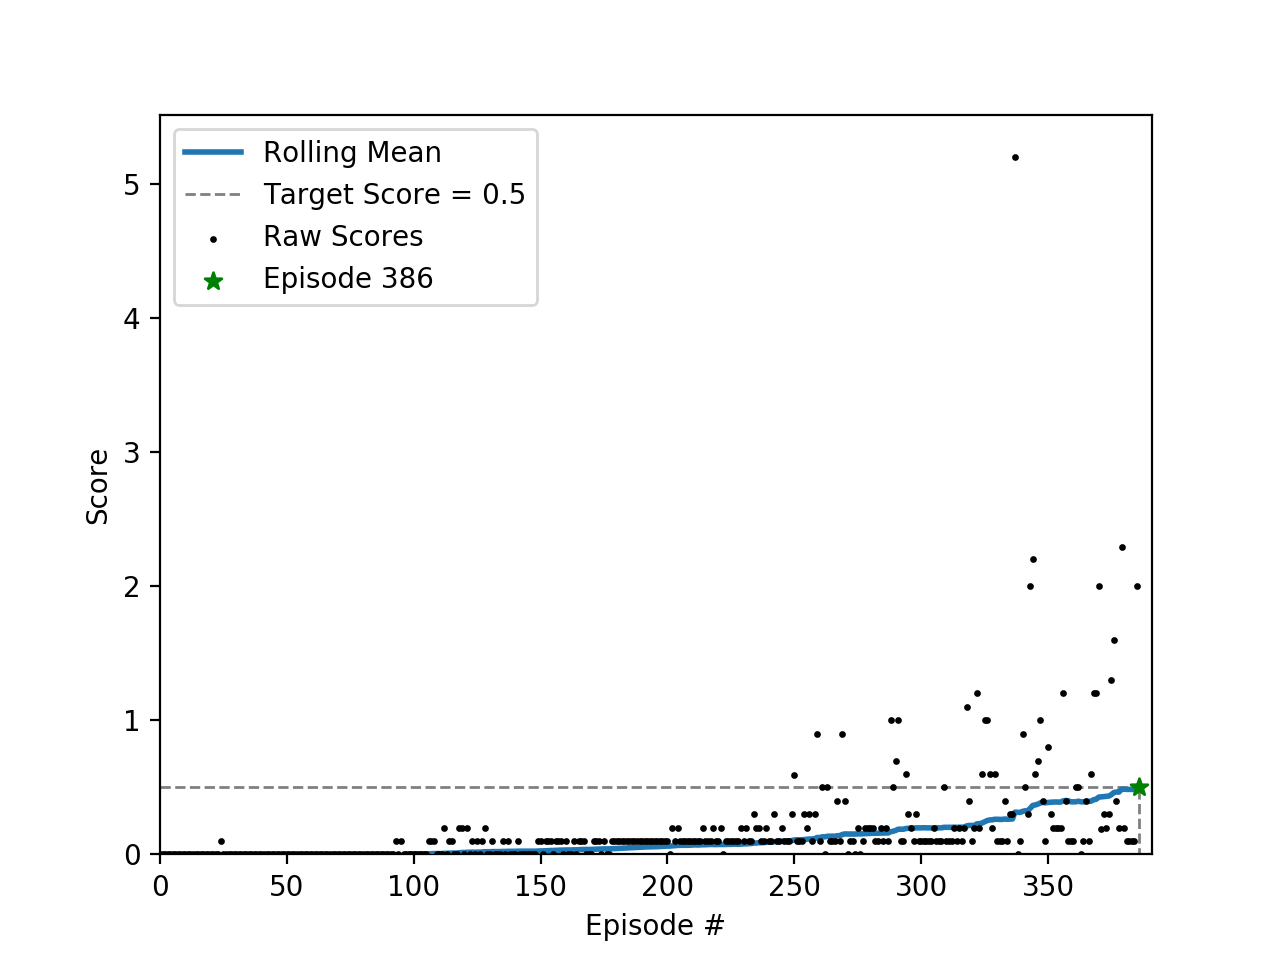

In [40]:
Image(filename='scores.png') 

#### Compare to the manually tuned model
As you can see the manually tuned model took 1724 episodes as compared to the optimal 386.
![scores](scores-initial.png)

# Reference
- [SageMaker Tuning Example](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/hyperparameter_tuning/pytorch_mnist)
- [How Hyperparameter Tuning Works](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html)
- [Tuner API](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html)
- [Estimater API](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.EstimatorBase)